# Analyse du risque de défaillance des joints toriques de la navette Challenger

Le 27 Janvier 1986, veille du décollage de la navette *Challenger*, eu
lieu une télé-conférence de trois heures entre les ingénieurs de la
Morton Thiokol (constructeur d'un des moteurs) et de la NASA. La
discussion portait principalement sur les conséquences de la
température prévue au moment du décollage de 31°F (juste en dessous de
0°C) sur le succès du vol et en particulier sur la performance des
joints toriques utilisés dans les moteurs. En effet, aucun test
n'avait été effectué à cette température.

L'étude qui suit reprend donc une partie des analyses effectuées cette
nuit là et dont l'objectif était d'évaluer l'influence potentielle de
la température et de la pression à laquelle sont soumis les joints
toriques sur leur probabilité de dysfonctionnement. Pour cela, nous
disposons des résultats des expériences réalisées par les ingénieurs
de la NASA durant les 6 années précédant le lancement de la navette
Challenger.



## Chargement des données
Nous commençons donc par charger ces données:

In [9]:
import numpy as np
import pandas as pd
data = pd.read_csv("shuttle.csv")
data

Date  Count  Temperature  Pressure  Malfunction
0    4/12/81      6           66        50            0
1   11/12/81      6           70        50            1
2    3/22/82      6           69        50            0
3   11/11/82      6           68        50            0
4    4/04/83      6           67        50            0
5    6/18/82      6           72        50            0
6    8/30/83      6           73       100            0
7   11/28/83      6           70       100            0
8    2/03/84      6           57       200            1
9    4/06/84      6           63       200            1
10   8/30/84      6           70       200            1
11  10/05/84      6           78       200            0
12  11/08/84      6           67       200            0
13   1/24/85      6           53       200            2
14   4/12/85      6           67       200            0
15   4/29/85      6           75       200            0
16   6/17/85      6           70       200            0
17   7/29/85      6           81       200            0
18   8/27/85      6           76       200            0
19  10/03/85      6           79       200            0
20  10/30/85      6           75       200            2
21  11/26/85      6           76       200            0
22   1/12/86      6           58       200            1

Le jeu de données nous indique la date de l'essai, le nombre de joints
toriques mesurés (il y en a 6 sur le lançeur principal), la
température (en Farenheit) et la pression (en psi), et enfin le
nombre de dysfonctionnements relevés. 

## Inspection graphique des données
Les vols où aucun incident n'est relevé n'apportant aucun information
sur l'influence de la température ou de la pression sur les
dysfonctionnements, nous nous concentrons sur les expériences où au
moins un joint a été défectueux.


**doesn't seem right. If with t1 we laucnh 1000 times and get 500 failures and with t2 we launch 500 times and get 500 failures. t2 should be considered more problematic.**

In [13]:
#data = data[data.Malfunction>0]
data["celcius"] = (5/9)*(data["Temperature"]-32)
data.sort_values(by='celcius')

Date  Count  Temperature  Pressure  Malfunction    celcius
13   1/24/85      6           53       200            2  11.666667
8    2/03/84      6           57       200            1  13.888889
22   1/12/86      6           58       200            1  14.444444
9    4/06/84      6           63       200            1  17.222222
0    4/12/81      6           66        50            0  18.888889
14   4/12/85      6           67       200            0  19.444444
12  11/08/84      6           67       200            0  19.444444
4    4/04/83      6           67        50            0  19.444444
3   11/11/82      6           68        50            0  20.000000
2    3/22/82      6           69        50            0  20.555556
1   11/12/81      6           70        50            1  21.111111
16   6/17/85      6           70       200            0  21.111111
7   11/28/83      6           70       100            0  21.111111
10   8/30/84      6           70       200            1  21.111111
5    6/18/82      6           72        50            0  22.222222
6    8/30/83      6           73       100            0  22.777778
15   4/29/85      6           75       200            0  23.888889
20  10/30/85      6           75       200            2  23.888889
18   8/27/85      6           76       200            0  24.444444
21  11/26/85      6           76       200            0  24.444444
11  10/05/84      6           78       200            0  25.555556
19  10/03/85      6           79       200            0  26.111111
17   7/29/85      6           81       200            0  27.222222

Très bien, nous avons une variabilité de température importante mais
la pression est quasiment toujours égale à 200, ce qui devrait
simplifier l'analyse.

Comment la fréquence d'échecs varie-t-elle avec la température ?


**It seems risky to discard a variable just like that. Pressure seems important, why not keep it and decide afterwrads.**

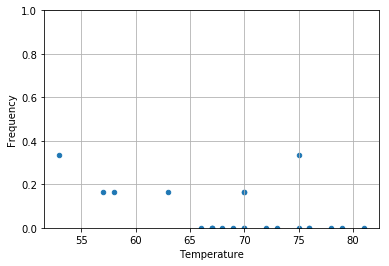

In [15]:
%matplotlib inline
pd.set_option('mode.chained_assignment',None) # this removes a useless warning from pandas
import matplotlib.pyplot as plt

data["Frequency"]=data.Malfunction/data.Count
data.plot(x="Temperature",y="Frequency",kind="scatter",ylim=[0,1])
plt.grid(True)

**No experiment worked below 65 degrees...**

À première vue, ce n'est pas flagrant mais bon, essayons quand même
d'estimer l'impact de la température $t$ sur la probabilité de
dysfonctionnements d'un joint. 


## Estimation de l'influence de la température

Supposons que chacun des 6 joints toriques est endommagé avec la même
probabilité et indépendamment des autres et que cette probabilité ne
dépend que de la température. Si on note $p(t)$ cette probabilité, le
nombre de joints $D$ dysfonctionnant lorsque l'on effectue le vol à
température $t$ suit une loi binomiale de paramètre $n=6$ et
$p=p(t)$. Pour relier $p(t)$ à $t$, on va donc effectuer une
régression logistique.

In [17]:
import statsmodels.api as sm

data["Success"]=data.Count-data.Malfunction
data["Intercept"]=1
data.sort_values(by='celcius')

Date  Count  Temperature  Pressure  Malfunction    celcius  Success  \
13   1/24/85      6           53       200            2  11.666667        4   
8    2/03/84      6           57       200            1  13.888889        5   
22   1/12/86      6           58       200            1  14.444444        5   
9    4/06/84      6           63       200            1  17.222222        5   
0    4/12/81      6           66        50            0  18.888889        6   
14   4/12/85      6           67       200            0  19.444444        6   
12  11/08/84      6           67       200            0  19.444444        6   
4    4/04/83      6           67        50            0  19.444444        6   
3   11/11/82      6           68        50            0  20.000000        6   
2    3/22/82      6           69        50            0  20.555556        6   
1   11/12/81      6           70        50            1  21.111111        5   
16   6/17/85      6           70       200            0  21.111111        6   
7   11/28/83      6           70       100            0  21.111111        6   
10   8/30/84      6           70       200            1  21.111111        5   
5    6/18/82      6           72        50            0  22.222222        6   
6    8/30/83      6           73       100            0  22.777778        6   
15   4/29/85      6           75       200            0  23.888889        6   
20  10/30/85      6           75       200            2  23.888889        4   
18   8/27/85      6           76       200            0  24.444444        6   
21  11/26/85      6           76       200            0  24.444444        6   
11  10/05/84      6           78       200            0  25.555556        6   
19  10/03/85      6           79       200            0  26.111111        6   
17   7/29/85      6           81       200            0  27.222222        6   

    Intercept  Frequency  
13          1   0.333333  
8           1   0.166667  
22          1   0.166667  
9           1   0.166667  
0           1   0.000000  
14          1   0.000000  
12          1   0.000000  
4           1   0.000000  
3           1   0.000000  
2           1   0.000000  
1           1   0.166667  
16          1   0.000000  
7           1   0.000000  
10          1   0.166667  
5           1   0.000000  
6           1   0.000000  
15          1   0.000000  
20          1   0.333333  
18          1   0.000000  
21          1   0.000000  
11          1   0.000000  
19          1   0.000000  
17          1   0.000000

In [25]:
logmodel=sm.GLM(data['Frequency'], data[['Intercept','Temperature']], family=sm.families.Binomial(sm.families.links.logit)).fit()

logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                   23
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.9210
Date:                Wed, 04 Jun 2025   Deviance:                       3.0144
Time:                        15:53:07   Pearson chi2:                     5.00
No. Iterations:                     6   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.0850      7.477      0.680      0.496      -9.570      19.740
Temperature    -0.1156      0.115     -1.004      0.316      -0.341       0.110
===============================================================================
"""

L'estimateur le plus probable du paramètre de température est 0.0014
et l'erreur standard de cet estimateur est de 0.122, autrement dit on
ne peut pas distinguer d'impact particulier et il faut prendre nos
estimations avec des pincettes.


## Estimation de la probabilité de dysfonctionnant des joints toriques
La température prévue le jour du décollage est de 31°F. Essayons
d'estimer la probabilité de dysfonctionnement des joints toriques à
cette température à partir du modèle que nous venons de construire:


In [21]:
data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Intercept': 1})
data_pred

Intercept  Temperature
0            1         30.0
1            1         30.5
2            1         31.0
3            1         31.5
4            1         32.0
5            1         32.5
6            1         33.0
7            1         33.5
8            1         34.0
9            1         34.5
10           1         35.0
11           1         35.5
12           1         36.0
13           1         36.5
14           1         37.0
15           1         37.5
16           1         38.0
17           1         38.5
18           1         39.0
19           1         39.5
20           1         40.0
21           1         40.5
22           1         41.0
23           1         41.5
24           1         42.0
25           1         42.5
26           1         43.0
27           1         43.5
28           1         44.0
29           1         44.5
..         ...          ...
91           1         75.5
92           1         76.0
93           1         76.5
94           1         77.0
95           1         77.5
96           1         78.0
97           1         78.5
98           1         79.0
99           1         79.5
100          1         80.0
101          1         80.5
102          1         81.0
103          1         81.5
104          1         82.0
105          1         82.5
106          1         83.0
107          1         83.5
108          1         84.0
109          1         84.5
110          1         85.0
111          1         85.5
112          1         86.0
113          1         86.5
114          1         87.0
115          1         87.5
116          1         88.0
117          1         88.5
118          1         89.0
119          1         89.5
120          1         90.0

[121 rows x 2 columns]

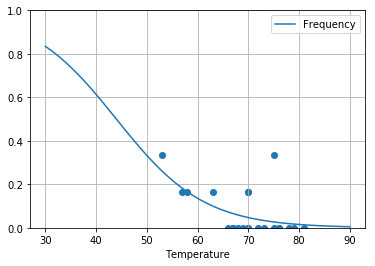

In [22]:
%matplotlib inline
data_pred['Frequency'] = logmodel.predict(data_pred[['Intercept','Temperature']])
data_pred.plot(x="Temperature",y="Frequency",kind="line",ylim=[0,1])
plt.scatter(x=data["Temperature"],y=data["Frequency"])
plt.grid(True)

In [23]:
data_pred

Intercept  Temperature  Frequency
0            1         30.0   0.834373
1            1         30.5   0.826230
2            1         31.0   0.817774
3            1         31.5   0.809002
4            1         32.0   0.799911
5            1         32.5   0.790500
6            1         33.0   0.780766
7            1         33.5   0.770712
8            1         34.0   0.760339
9            1         34.5   0.749648
10           1         35.0   0.738645
11           1         35.5   0.727334
12           1         36.0   0.715721
13           1         36.5   0.703816
14           1         37.0   0.691626
15           1         37.5   0.679164
16           1         38.0   0.666441
17           1         38.5   0.653471
18           1         39.0   0.640269
19           1         39.5   0.626851
20           1         40.0   0.613235
21           1         40.5   0.599439
22           1         41.0   0.585485
23           1         41.5   0.571391
24           1         42.0   0.557181
25           1         42.5   0.542876
26           1         43.0   0.528501
27           1         43.5   0.514078
28           1         44.0   0.499631
29           1         44.5   0.485186
..         ...          ...        ...
91           1         75.5   0.025508
92           1         76.0   0.024110
93           1         76.5   0.022787
94           1         77.0   0.021535
95           1         77.5   0.020350
96           1         78.0   0.019229
97           1         78.5   0.018169
98           1         79.0   0.017166
99           1         79.5   0.016217
100          1         80.0   0.015321
101          1         80.5   0.014473
102          1         81.0   0.013671
103          1         81.5   0.012913
104          1         82.0   0.012197
105          1         82.5   0.011520
106          1         83.0   0.010880
107          1         83.5   0.010275
108          1         84.0   0.009703
109          1         84.5   0.009163
110          1         85.0   0.008653
111          1         85.5   0.008171
112          1         86.0   0.007716
113          1         86.5   0.007286
114          1         87.0   0.006879
115          1         87.5   0.006496
116          1         88.0   0.006133
117          1         88.5   0.005791
118          1         89.0   0.005467
119          1         89.5   0.005162
120          1         90.0   0.004873

[121 rows x 3 columns]

# 0.81 !

In [32]:
from scipy.stats import binom

n = 6
p = 0.81

prob = 0
for k in range(2,7):
    prob += binom.pmf(k, n, p)
print(f"P(X <= 2) = {prob:.4f}")

P(X <= 2) = 0.9987


## je ne comprends pas le raisonnement en bas !

Comme on pouvait s'attendre au vu des données initiales, la
température n'a pas d'impact notable sur la probabilité d'échec des
joints toriques. Elle sera d'environ 0.2, comme dans les essais
précédents où nous il y a eu défaillance d'au moins un joint. Revenons
à l'ensemble des données initiales pour estimer la probabilité de
défaillance d'un joint:


In [6]:
data = pd.read_csv("shuttle.csv")
print(np.sum(data.Malfunction)/np.sum(data.Count))

0.06521739130434782


Cette probabilité est donc d'environ $p=0.065$, sachant qu'il existe
un joint primaire un joint secondaire sur chacune des trois parties du
lançeur, la probabilité de défaillance des deux joints d'un lançeur
est de $p^2 \approx 0.00425$. La probabilité de défaillance d'un des
lançeur est donc de $1-(1-p^2)^3 \approx 1.2%$.  Ça serait vraiment
pas de chance... Tout est sous contrôle, le décollage peut donc avoir
lieu demain comme prévu.

Seulement, le lendemain, la navette Challenger explosera et emportera
avec elle ses sept membres d'équipages. L'opinion publique est
fortement touchée et lors de l'enquête qui suivra, la fiabilité des
joints toriques sera directement mise en cause. Au delà des problèmes
de communication interne à la NASA qui sont pour beaucoup dans ce
fiasco, l'analyse précédente comporte (au moins) un petit
problème... Saurez-vous le trouver ? Vous êtes libre de modifier cette
analyse et de regarder ce jeu de données sous tous les angles afin
d'expliquer ce qui ne va pas.